# Examples and tutorial for Variational Bayesian Monte Carlo

In [2]:
import numpy as np
from pyvbmc.vbmc import VBMC

In this notebook, we will present various example usages for Variational Bayesian Monte Carlo (VBMC).

## Example 1: Basic usage

#### Simple usage of VBMC having as target log likelihood Rosenbrock's banana function

We set as toy log likelihood for our model a broad [Rosenbrock's banana function](https://en.wikipedia.org/wiki/Rosenbrock_function) in 2D.

In [4]:
D = 2 # We consider a 2-D problem

# Log likelihood of the model
def llfun(x):
    x = np.atleast_2d(x)
    return -np.sum(
                (x[0, :-1] ** 2.0 - x[0, 1:]) ** 2.0
                + (x[0, :-1] - 1) ** 2.0 / 100
            )

# In general, llfun would define the log likelihood of *your* model

We define now a prior over the parameters. For simplicity, we set an independent Gaussian prior on each variable, but you could use any prior of your choice.

In [5]:
prior_mu = np.zeros((1,D))
prior_var = 3**2*np.ones((1,D))
lpriorfun = lambda x: (-0.5*np.sum((x-prior_mu)**2 / prior_var,axis=1)
                        -0.5*np.log(np.prod(2*np.pi*prior_var)))

So our log joint (that is, unnormalized log posterior density), is:

In [6]:
fun = lambda x: llfun(x) + lpriorfun(x)

We assume an unconstrained domain for the model parameters, and finite plausible bounds which should denote a region of high posterior  probability mass. Not knowing better, we use mean +/- 1 SD of the prior (that is, the top ~68% prior credible interval) to set plausible bounds.

In [9]:
LB = -np.full((1,D), np.inf)                 # Lower bounds
UB = np.full((1,D), np.inf)                  # Upper bounds
PLB = prior_mu - np.sqrt(prior_var)          # Plausible lower bounds
PUB = prior_mu + np.sqrt(prior_var)          # Plausible upper bounds

# Alternatively, you could set the plausible bounds using the quantiles:
# from scipy.stats import norm
# PLB = norm.ppf(0.1587,prior_mu,np.sqrt(prior_var))
# PUB = norm.ppf(0.8413,prior_mu,np.sqrt(prior_var))

As a starting point for the algorithm, we use the mean of the prior:

In [11]:
x0 = np.copy(prior_mu)

# Alternatively, we could use a random sample from inside the plausible box:
# x0 = PLB + np.random.uniform(size=(1,D))*(PUB - PLB)

We now initialize the `VBMC` object.  For now, we use default options for the inference.

In [13]:
vbmc = VBMC(fun, x0, LB, UB, PLB, PUB)

To perform inference, we run `vbmc.optimize()`. The algorithm returns the variational posterior `vp`, the lower bound on the log model evidence `elbo`, and its uncertainty `elbo_sd`.

In [14]:
vp, elbo, elbo_sd, _, _ = vbmc.optimize()

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10          -2.75         0.58      2371.95        2        inf     start warm-up
     1         15          -2.79         0.06         8.26        2        inf     
     2         20          -2.80         0.01         0.09        2       2.22     
     3         25          -2.78         0.00         0.00        2      0.091     
     4         30          -2.78         0.00         0.00        2     0.0335     end warm-up
     5         35          -2.79         0.00         0.01        2      0.163     
     6         40          -2.76         0.00         0.01        2      0.212     
     7         45          -2.50         0.00         0.25        5       6.85     
     8         50          -2.44         0.00         0.02        6      0.795     
     9         55          -2.39         0.00    

In [20]:
lml_true = -2.272 # ground truth, which we know for this toy scenario

print("The true log model evidence is:", lml_true)
print("The obtained ELBO is:", format(elbo, '.3f'))
print("The obtained ELBO_SD is:", format(elbo_sd, '.3f'))

The true log model evidence is: -2.272
The obtained ELBO is: -2.298
The obtained ELBO_SD is: 0.001


#### Remarks:
- VBMC does not aim for high numerical precision (e.g., beyond the 1st or 2nd decimal place). In most realistic model-fitting problems, a higher resolution is not particularly useful.
- The ELBO is a *lower bound* on the true log model evidence.
- The reported standard deviation of the ELBO, `elbo_sd`, is a measure of the uncertainty on the ELBO as estimated via Bayesian quadrature (the approximation technique used by VBMC). `elbo_sd` is **not** a measure of the difference between the ELBO and the true log model evidence, which is generally unknown. 

We can now examine the obtained variational posterior.

For reporting uncertainty on model parameter estimates, you could use posterior mean +/- SD, or the median and interquartile range (the latter is better for a posterior that deviates substantially from Gaussian).

In [31]:
# First, generate a large number of samples from the variational posterior:
n_samples = int(3e5)
Xs, _ = vp.sample(n_samples)

# Easily compute statistics such as moments, credible intervals, etc.
post_mean = np.mean(Xs,axis=0)             # Posterior mean
post_cov = np.cov(Xs.T)                    # Posterior covariance matrix
print("The approximate posterior mean is:", post_mean)
print("The approximate posterior covariance matrix is:\n", post_cov)

The approximate posterior mean is: [-0.01806583  1.08081628]
The approximate posterior covariance matrix is:
 [[ 1.14703364 -0.09603111]
 [-0.09603111  1.73263202]]


Finally, we visualize the obtained variational approximation `vp` via the `vp.plot()` function, which is based on the beautiful `corner.py` module (see [here]((https://corner.readthedocs.io/en/latest/))).

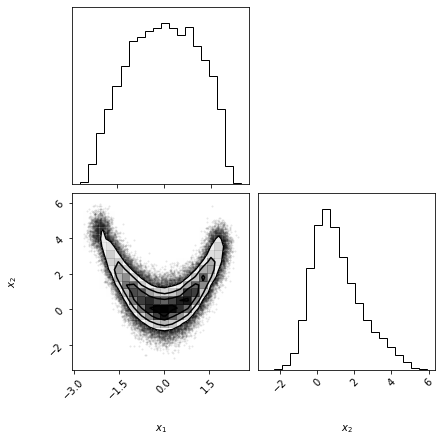

In [29]:
_ = vp.plot()

The figure represents the multidimensional posterior `vp` via one- and two-dimensional marginal plots for each variable and pairs of variables.

Here, the bottom-left panel represents the two-dimensional joint distribution of $x_1$ and $x_2$, whereas the two panels on the diagonal represent the one-dimensional marginal distributions of $x_1$ and $x_2$, respectively. Note that VBMC has managed to approximate very well the highly non-Gaussian shape of the target.

### Example 1 full code

The following cell includes in a single place all the code used in Example 1 without the extra fluff.

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10          -2.12         3.78      6482.70        2        inf     start warm-up
     1         15          -3.07         0.16         0.78        2        inf     
     2         20          -2.81         0.02         0.33        2       8.74     
     3         25          -2.80         0.00         0.01        2      0.234     
     4         30          -2.79         0.00         0.01        2       0.32     end warm-up
     5         35          -2.77         0.00         0.00        2       0.15     
     6         40          -2.79         0.00         0.01        2      0.202     
     7         45          -2.52         0.00         0.17        5       4.89     
     8         50          -2.47         0.00         0.01        6      0.362     
     9         55          -2.42         0.00    

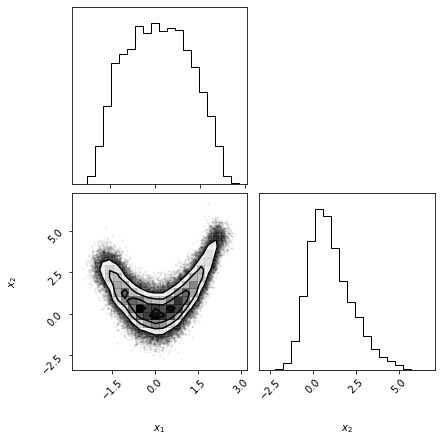

In [72]:
import numpy as np
from pyvbmc.vbmc import VBMC

#####################################################################
# Define log likelihood, log prior, and log joint

D = 2

def llfun(x):
    x = np.atleast_2d(x)
    return -np.sum(
                (x[0, :-1] ** 2.0 - x[0, 1:]) ** 2.0
                + (x[0, :-1] - 1) ** 2.0 / 100
            )

prior_mu = np.zeros((1,D))
prior_var = 3**2*np.ones((1,D))
lpriorfun = lambda x: (-0.5*np.sum((x-prior_mu)**2 / prior_var,axis=1)
                        -0.5*np.log(np.prod(2*np.pi*prior_var)))

fun = lambda x: llfun(x) + lpriorfun(x)

#####################################################################
# Define bounds and starting point

LB = -np.full((1,D), np.inf)                 # Lower bounds
UB = np.full((1,D), np.inf)                  # Upper bounds
PLB = prior_mu - np.sqrt(prior_var)          # Plausible lower bounds
PUB = prior_mu + np.sqrt(prior_var)          # Plausible upper bounds
# from scipy.stats import norm
# PLB = norm.ppf(0.159,prior_mu,np.sqrt(prior_var))
# PUB = norm.ppf(0.841,prior_mu,np.sqrt(prior_var))

x0 = np.copy(prior_mu)
# x0 = PLB + np.random.uniform(size=(1,D))*(PUB - PLB)

#####################################################################
# Initialize and run VBMC

vbmc = VBMC(fun, x0, LB, UB, PLB, PUB)
vp, elbo, elbo_sd, _, _ = vbmc.optimize()

#####################################################################
# Analyze and visualize results

n_samples = int(3e5)
Xs, _ = vp.sample(n_samples)
post_mean = np.mean(Xs,axis=0)
post_cov = np.cov(Xs.T)
print("The approximate posterior mean is:", post_mean)
print("The approximate posterior covariance matrix is:\n", post_cov)

_ = vp.plot()

## Example 2: Bound parameters
As in Example 1, but we assume parameters are constrained to be positive. We also display the evolution of the variational posterior in each iteration.

In [32]:
D = 2 # still in 2-D

# log likelihood (Rosenbrock)
def llfun(x):
    x = np.atleast_2d(x)
    return -np.sum(
                (x[0, :-1] ** 2.0 - x[0, 1:]) ** 2.0
                + (x[0, :-1] - 1) ** 2.0 / 100
            )

Since parameters are positive, we impose an exponential prior (again, you could choose whatever you want).

In [54]:
import scipy.stats as scs

prior_tau = 3*np.ones((1,D))            # Length scale of the exponential prior
lpriorfun = lambda x: np.sum(scs.expon.logpdf(x, scale=prior_tau))

# Log joint
fun = lambda x: llfun(x) + lpriorfun(x)        

Bound settings require some discussion:
1) the specified bounds are **not** included in the domain, so in this case, 
   since we want to be the parameters to be positive, we can set `LB = 0`, 
   knowing that the parameter will always be greater than zero.

In [34]:
LB = np.zeros((1,D))                           # Lower bounds

2) Currently, VBMC does not support half-bounds, so we need to specify
    a finite upper bound (cannot be `Inf`). We pick something very large
    according to our prior. However, do not go crazy here by picking 
    something impossibly large, otherwise VBMC will fail.

In [35]:
UB = 10*prior_tau                              # Upper bounds

3) Plausible bounds need to be meaningfully different from hard bounds,
so here we cannot pick `PLB = 0`. We follow the same strategy as the first
   example, by picking the top ~68% credible interval of the prior.

In [42]:
PLB = scs.expon.ppf(0.159,scale=prior_tau)
PUB = scs.expon.ppf(0.841,scale=prior_tau)

Good practice is to initialize VBMC in a region of high posterior density. For this example, we cheat and start in the proximity of the mode, which is near the optimum of the likelihood (which we know).

In [56]:
x0 = np.ones((1,D))             # Optimum of the Rosenbrock function

Finally, we initialize and run VBMC. In this example, we switch on the plotting of the current variational posterior at each iteration with the user option `plot`. A few remarks:

- In each plot, blue circles represent points in the training set, and orange dots are points added to the training set in this iteration. The red crosses are the centers of the variational mixture components.
- Since VBMC with plotting on can occupy a lot of space on the notebook, remember that in Jupyter notebook you can toggle the scrolling on and off via the "Cell > Current Outputs" and "Cell > All Output" menus.

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10           6.06        85.72    209094.28        2        inf     start warm-up


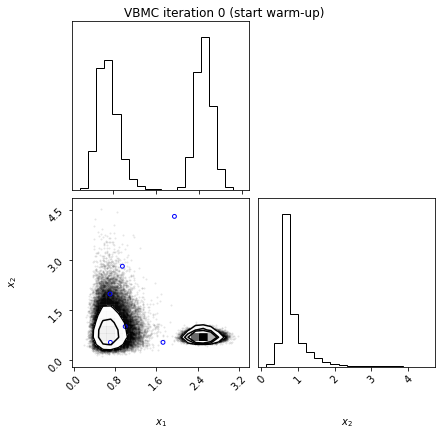

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     1         15          49.28        20.15         0.40        2        inf     


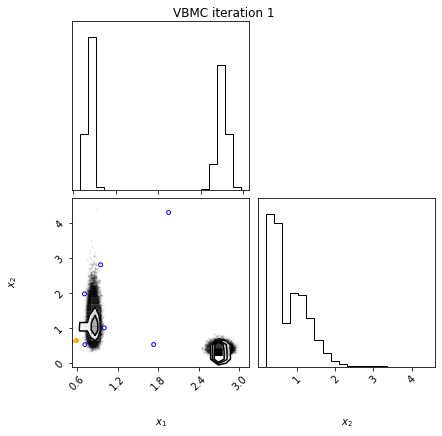

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     2         20           4.43         8.08        29.91        2        881     


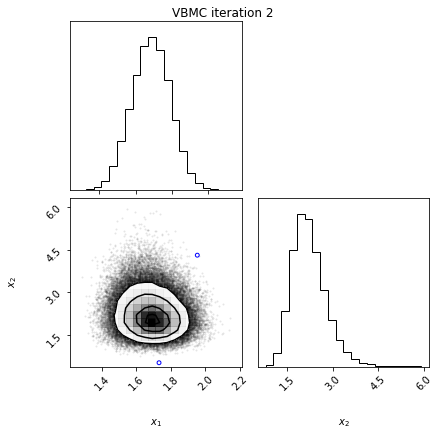

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     3         25          -1.96         2.33        18.51        2        465     


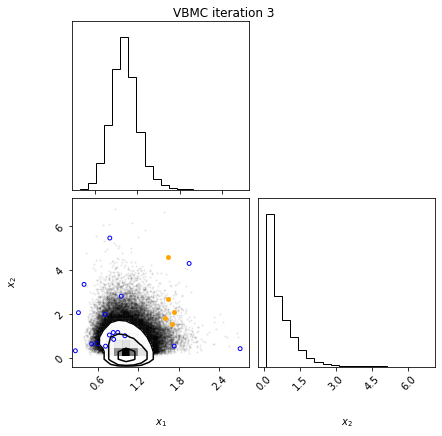

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     4         30          -2.44         0.08         0.87        2       22.3     end warm-up


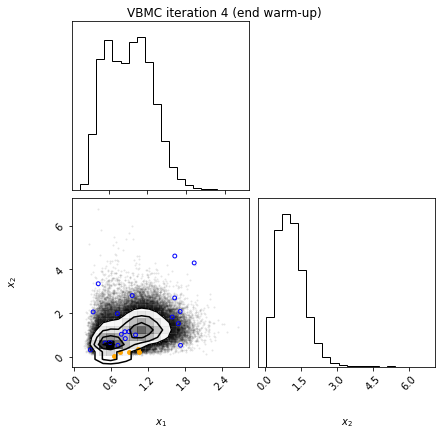

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     5         35          -2.37         0.06         0.10        2       2.79     


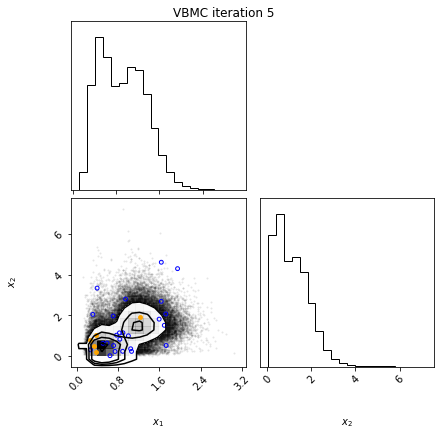

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     6         40          -2.32         0.04         0.02        2      0.725     


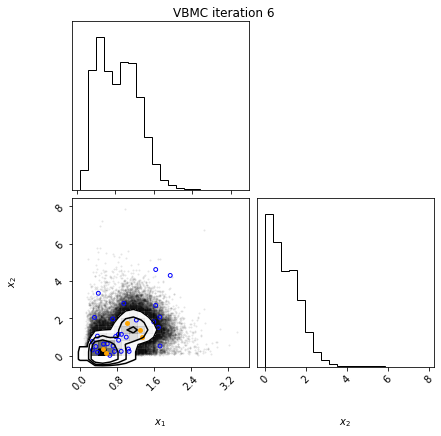

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     7         45          -2.17         0.12         0.05        5       1.97     


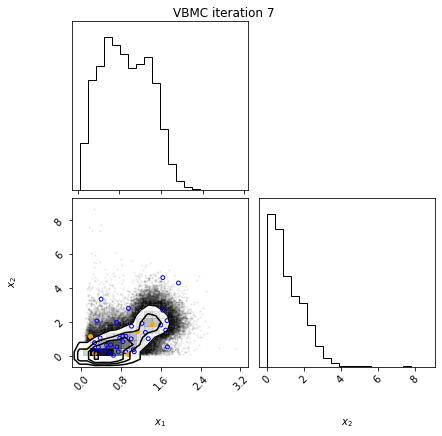

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     8         50          -2.13         0.03         0.01        5      0.507     


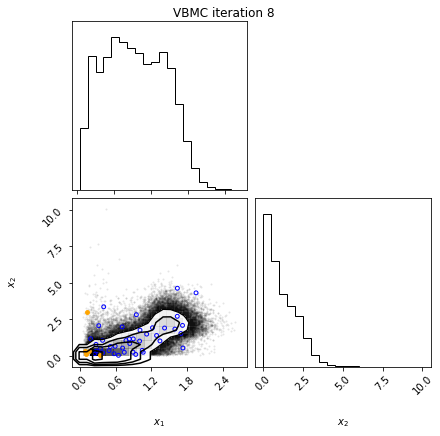

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     9         55          -2.02         0.02         0.02        8       1.02     


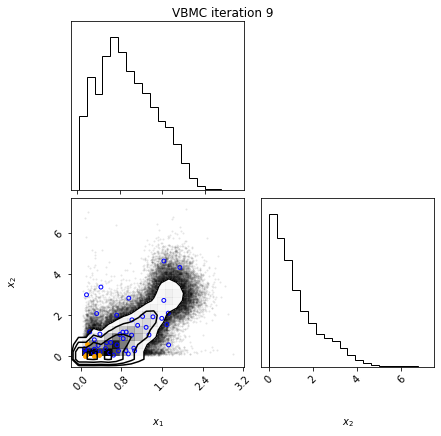

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    10         60          -2.00         0.02         0.00        9      0.175     


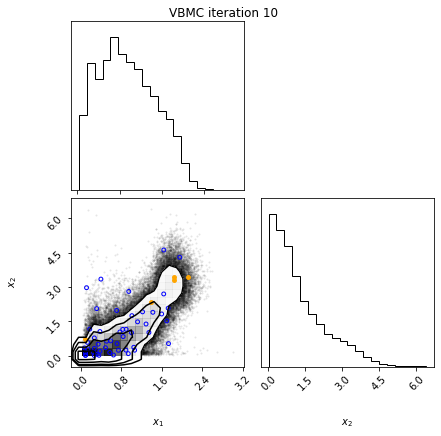

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    11         65          -1.88         0.08         0.07       12       2.06     


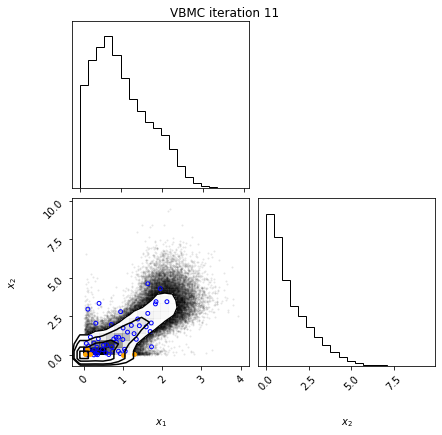

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    12         70          -1.93         0.55         0.05       12       3.25     


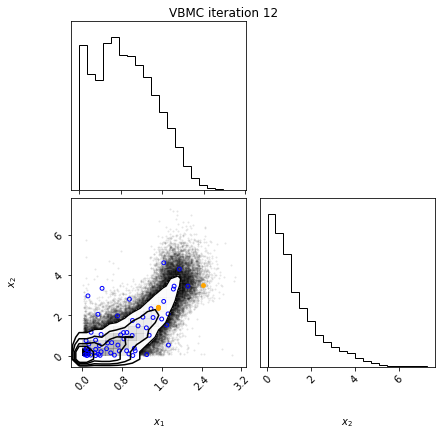

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    13         75          -1.94         0.01         0.00       12      0.202     


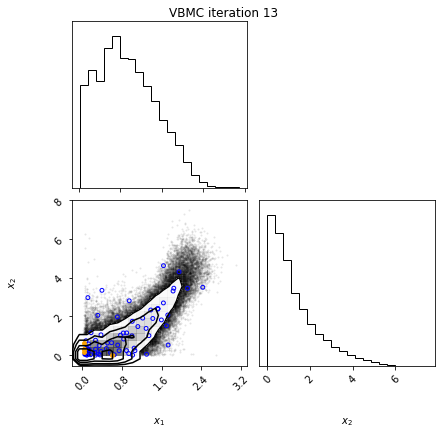

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    14         80          -1.92         0.01         0.02       15      0.539     


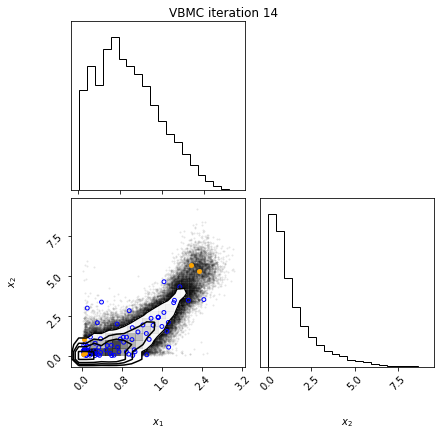

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    15         85          -1.91         0.00         0.01       17      0.163     


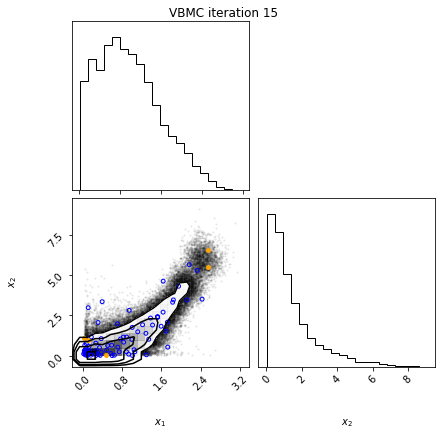

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    16         90          -1.90         0.00         0.00       17     0.0691     


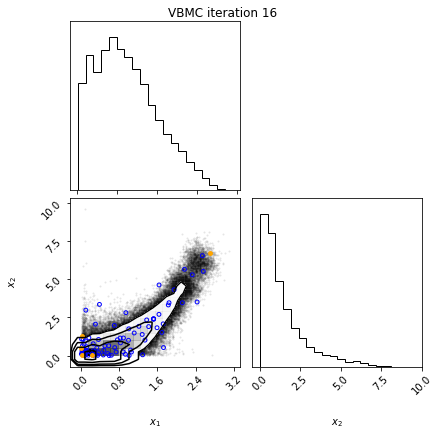

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    17         95          -1.91         0.00         0.00       18     0.0484     


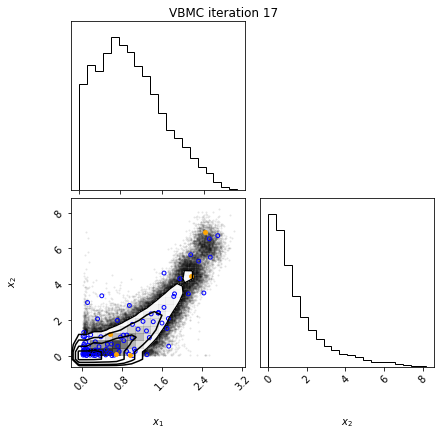

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    18        100          -1.90         0.00         0.00       18     0.0448     


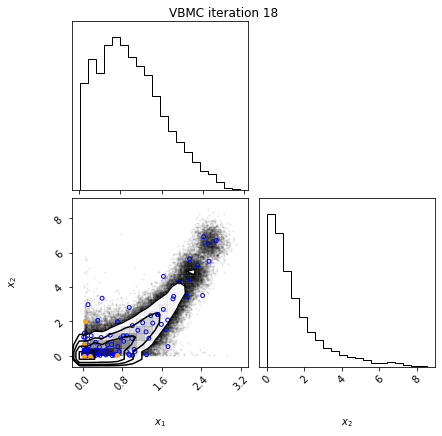

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    19        105          -1.90         0.01         0.01       21      0.164     


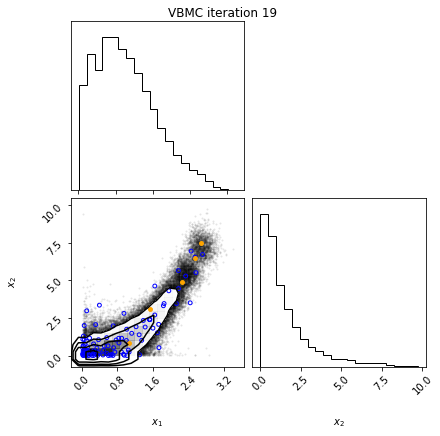

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    20        110          -1.89         0.00         0.00       21     0.0589     


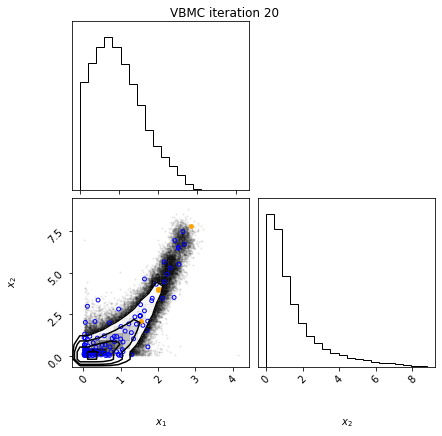

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    21        115          -1.89         0.00         0.00       22     0.0262     stable


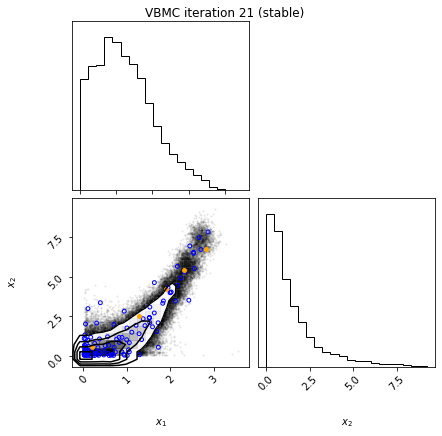

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
   inf        115          -1.88         0.00         0.00       50     0.0262     finalize


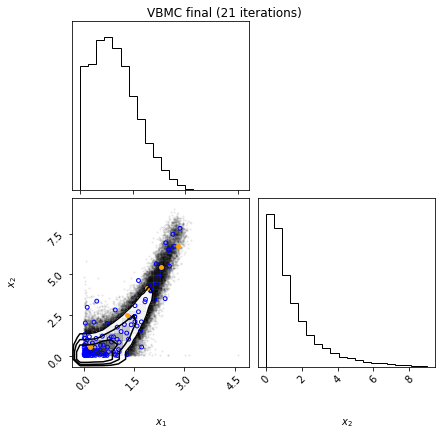

Inference terminated: variational solution stable for options.tolstablecountfcn evaluations.
Estimated ELBO: -1.880 +/-0.002.


In [58]:
# initialize VBMC
user_options = {"plot": True}
vbmc = VBMC(fun, x0, LB, UB, PLB, PUB, user_options)

# run VBMC
vp, elbo, elbo_sd, _, _ = vbmc.optimize()

In [59]:
lml_true = -1.836 # ground truth, which we know for this toy scenario

print("The true log model evidence is:", lml_true)
print("The obtained ELBO is:", format(elbo, '.3f'))
print("The obtained ELBO_SD is:", format(elbo_sd, '.3f'))

The true log model evidence is: -1.836
The obtained ELBO is: -1.880
The obtained ELBO_SD is: 0.002


We will examine now the obtained variational posterior with an interactive plot.

In [64]:
# Generate samples from the variational posterior
n_samples = int(3e5)
Xs, _ = vp.sample(n_samples)

# We compute the pdf of the approximate posterior on a 2-D grid
plot_lb = np.zeros(2)
plot_ub = np.quantile(Xs,0.999, axis=0)
x1 = np.linspace(plot_lb[0],plot_ub[0],400)
x2 = np.linspace(plot_lb[1],plot_ub[1],400)

xa, xb = np.meshgrid(x1,x2)                 # Build the grid
xx = np.vstack((xa.ravel(), xb.ravel())).T  # Convert grids to a vertical array of 2-D points
yy = vp.pdf(xx)                             # Compute PDF values on specified points

In [70]:
# Plot approximate posterior pdf (works only in 1-D and 2-D)
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=yy.reshape(x1.size,x2.size), x=x1, y=x2, showscale = False)])
fig.update_layout(autosize=False,
                  width=800, height=500,
                  scene = dict(
                    xaxis_title='x_1',
                    yaxis_title='x_2',
                    zaxis_title='Approximate posterior pdf'))

# Compute and plot approximate posterior mean
post_mean = np.mean(Xs, axis=0)
fig.add_trace(go.Scatter3d(x=[post_mean[0]], y=[post_mean[1]], z=vp.pdf(post_mean), name="Approximate posterior mean", marker_symbol="diamond"))

# Find and plot approximate posterior mode
post_mode = vp.mode()
fig.add_trace(go.Scatter3d(x=[post_mode[0]], y=[post_mode[1]], z=vp.pdf(post_mode), name="Approximate posterior mode", marker_symbol="x"))

c:\users\luigi\documents\github\pyvbmc\pyvbmc\parameter_transformer\parameter_transformer.py:128: RuntimeWarning:

invalid value encountered in log

c:\users\luigi\documents\github\pyvbmc\pyvbmc\parameter_transformer\parameter_transformer.py:128: RuntimeWarning:

divide by zero encountered in log

c:\users\luigi\documents\github\pyvbmc\pyvbmc\variational_posterior\variational_posterior.py:451: RuntimeWarning:

divide by zero encountered in log

c:\users\luigi\documents\github\pyvbmc\pyvbmc\parameter_transformer\parameter_transformer.py:229: RuntimeWarning:

invalid value encountered in add



In [65]:
from IPython.display import Image
Image(fig.to_image(format="png"))

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


array([0.69291367, 0.75282038])